# Preprocessing - Notebook 3
## Enhancing dataset

- Enhancing images with CLARE, Blur and sharp filter
- Resizing images with padding so all images are fixed size 128x128(for CNN)
- Augmented data to hande class imbalance
- Stratified training set into 5 K-folds


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from tqdm import tqdm
import random
import shutil
from collections import Counter
import imgaug as ia
from imgaug import augmenters as iaa

In [8]:
plt.style.use('ggplot')

#set up paths
projectRoot = Path().resolve().parent
datasetPath = projectRoot / "CV2024_CW_Dataset"
outputRoot = projectRoot / "ModifiedDataset"

# original dataset paths
trainImagePath = datasetPath / "train" / "images"
trainLabelPath = datasetPath / "train" / "labels"
testImagePath = datasetPath / "test" / "images"
testLabelPath = datasetPath / "test" / "labels"

# paths for enhanced imgs
enhancedTrainImagePath = outputRoot / "train" / "images"
enhancedTrainLabelPath = outputRoot / "train" / "labels"
enhancedTestImagePath = outputRoot / "test" / "images"
enhancedTestLabelPath = outputRoot / "test" / "labels"

# create output directories
for path in [enhancedTrainImagePath, enhancedTrainLabelPath, 
             enhancedTestImagePath, enhancedTestLabelPath]:
    path.mkdir(parents=True, exist_ok=True)

trainImages = sorted(os.listdir(trainImagePath))
testImages = sorted(os.listdir(testImagePath))

print("Dataset paths set up correctly.")

Dataset paths set up correctly.


In [9]:
def displayEnhancement(imageFolder, enhancementFunction, numSamples=3, functionName="Enhancement"):

    # get all images in folder and select random ones
    imageFiles = [f for f in os.listdir(imageFolder) if f.endswith(".jpeg")]
    randomImages = random.sample(imageFiles, numSamples)

    fig, axes = plt.subplots(numSamples, 2, figsize=(8, numSamples * 3))

    for i, imgFile in enumerate(randomImages):
        # load original img
        imgPath = os.path.join(imageFolder, imgFile)
        img = cv2.imread(imgPath)
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        # apply the enhancement function
        enhancedImg = enhancementFunction(img)
        enhancedImgRGB = cv2.cvtColor(enhancedImg, cv2.COLOR_BGR2RGB)

        # plot original
        axes[i, 0].imshow(imgRGB)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Original Image")

        # plot enhanced
        axes[i, 1].imshow(enhancedImgRGB)
        axes[i, 1].axis("off")
        axes[i, 1].set_title(f"{functionName}")

    plt.tight_layout()
    plt.show()

## Gaussian Blur (Noise Reduction)
Blurs the image to remove noise while preserving edges.


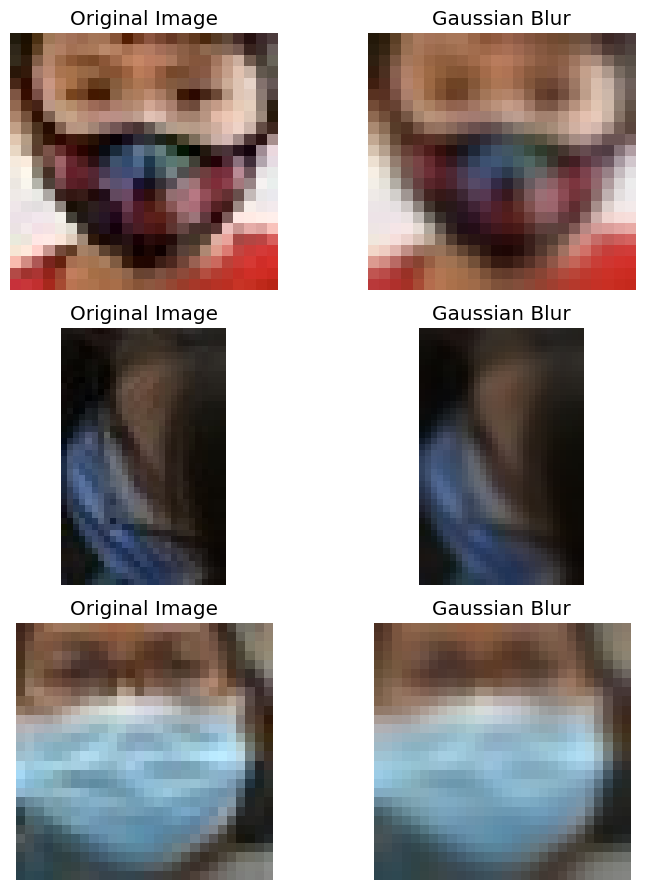

In [18]:
def applyGaussianBlur(img):

    return cv2.GaussianBlur(img, (3, 3), 0)


displayEnhancement(trainImagePath, applyGaussianBlur, numSamples=3, functionName="Gaussian Blur")


## Histogram Equalization (Contrast Enhancement)
Enhances image contrast by adjusting the brightness level


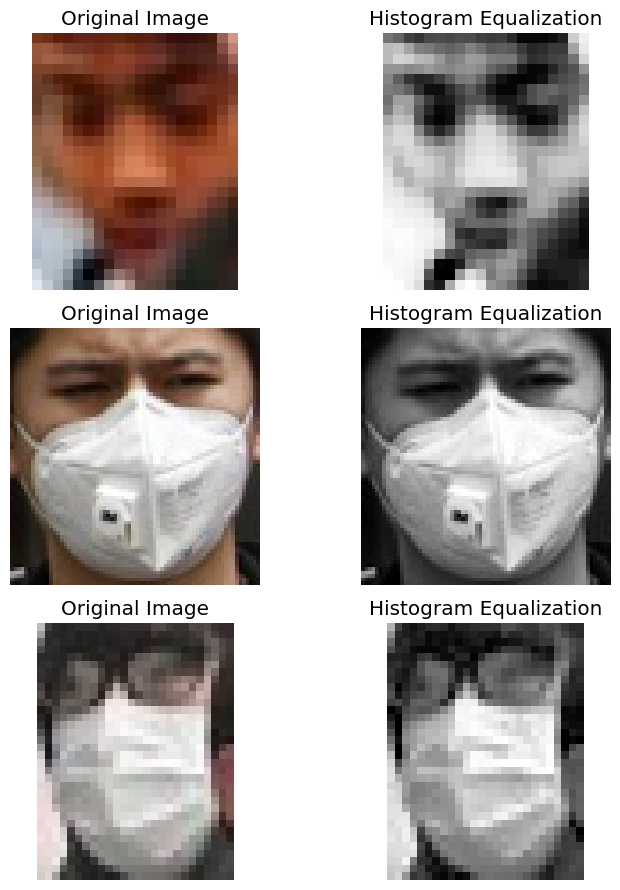

In [9]:
def applyHistogramEqualization(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    equalized = cv2.equalizeHist(gray)  
    return cv2.merge([equalized, equalized, equalized]) 

displayEnhancement(trainImagePath, applyHistogramEqualization, numSamples=3, functionName="Histogram Equalization")


## Adaptive Histogram Equalization (CLAHE)
Applying localized contrast improvement to prevent image from becoming too bright


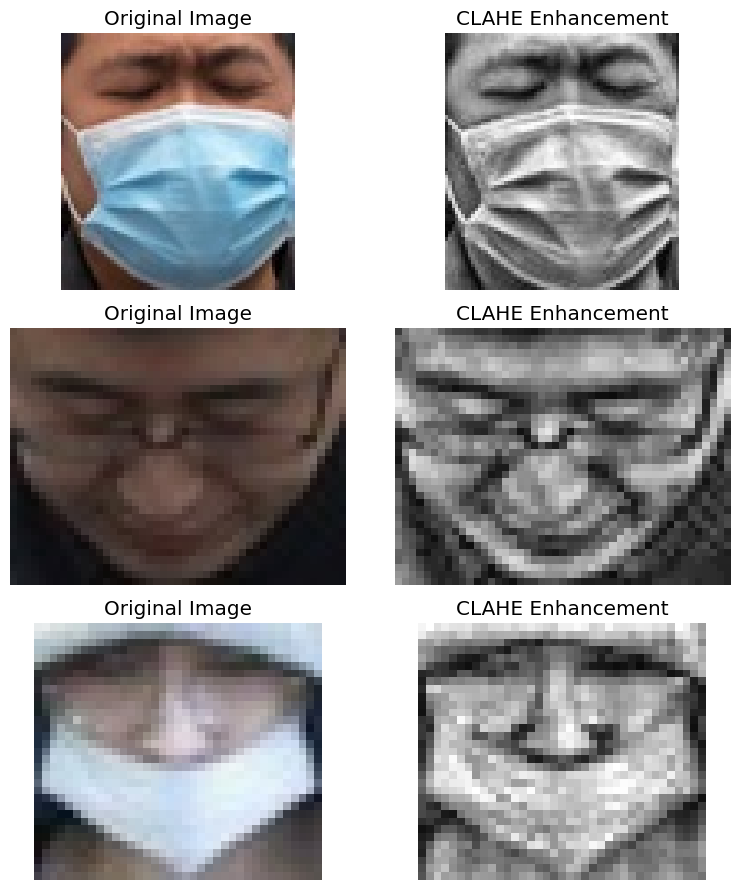

In [21]:
def applyCLAHE(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)
    return cv2.merge([equalized, equalized, equalized]) 


displayEnhancement(trainImagePath, applyCLAHE, numSamples=3, functionName="CLAHE Enhancement")


## Sharpening Filter
Enhances edges to make details more clear


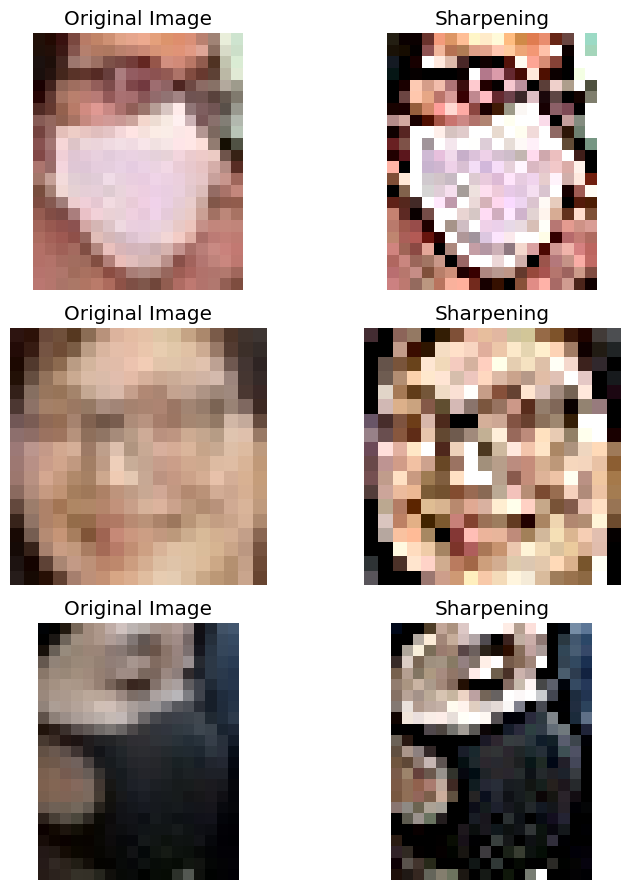

In [22]:
def applySharpening(img):

    sharpeningKernel = np.array([[0, -1, 0], 
                                 [-1, 5, -1], 
                                 [0, -1, 0]])
    return cv2.filter2D(img, -1, sharpeningKernel)

displayEnhancement(trainImagePath, applySharpening, numSamples=3, functionName="Sharpening")


## Edge Detection (Canny)
Detectecting strong edges in the image for future feature extraction


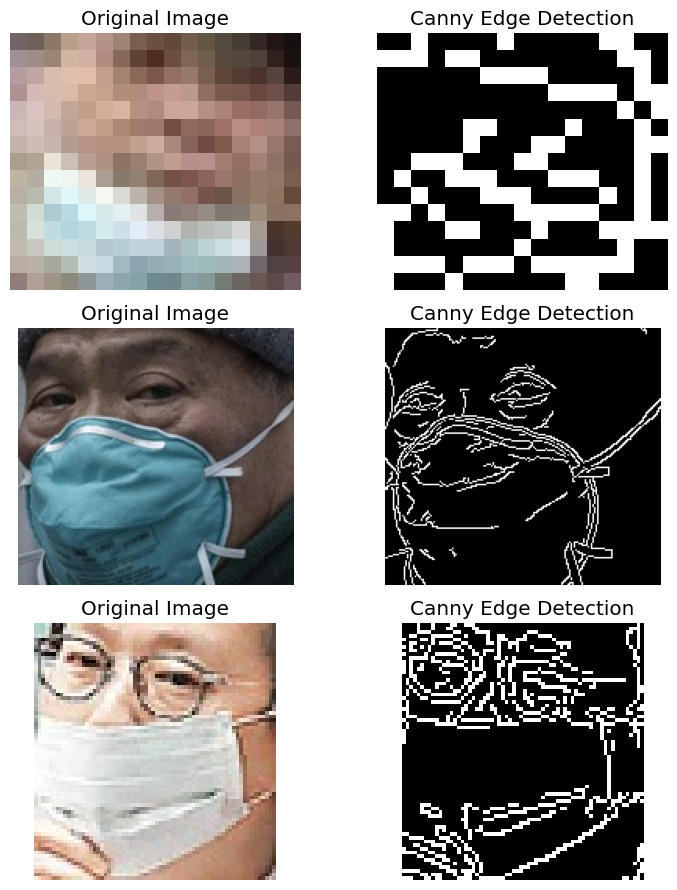

In [23]:
def applyCannyEdgeDetection(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)  
    return cv2.merge([edges, edges, edges])  

displayEnhancement(trainImagePath, applyCannyEdgeDetection, numSamples=3, functionName="Canny Edge Detection")


In [4]:
def applyMultiEnhancements(img):

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # apply CLAHE 
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # apply gaussian blur
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)

    # apply sharpening filter 
    sharpeningKernel = np.array([[0, -1, 0], 
                                 [-1, 5, -1], 
                                 [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, sharpeningKernel)

    # converting back to 3 channel grayscale
    finalImage = cv2.merge([sharpened, sharpened, sharpened])

    return finalImage

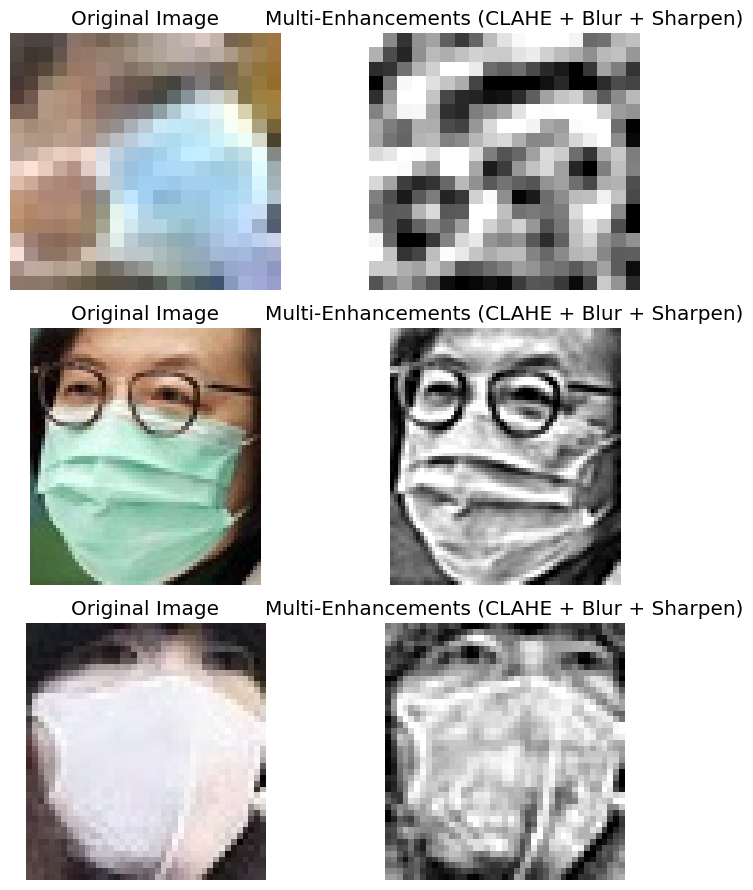

In [6]:
displayEnhancement(trainImagePath, applyMultiEnhancements, numSamples=3, functionName="Multi-Enhancements (CLAHE + Blur + Sharpen)")


## Resizing all images with padding 128x128

In [7]:
def resizeWithPadding(img, target_size=(128, 128)):
     # get current dimensions
    h, w = img.shape[:2]
    
    # calculate target dimensions also preserve aspect ratio
    target_w, target_h = target_size
    
    aspect = w / h
    
    if aspect > 1:  # Width > Height (landscape)
        new_w = target_w
        new_h = int(new_w / aspect)
    else:  # Height >= Width (portrait)
        new_h = target_h
        new_w = int(new_h * aspect)
     
    new_w = max(1, new_w)
    new_h = max(1, new_h)
    
    #resize the image
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # calculate padding
    delta_w = target_w - new_w
    delta_h = target_h - new_h
    top = delta_h // 2
    bottom = delta_h - top
    left = delta_w // 2
    right = delta_w - left
    
    # apply padding
    if len(img.shape) == 3:  # Color image (BGR)
        color = [0, 0, 0]
    else:  # Grayscale
        color = 0
        
    padded = cv2.copyMakeBorder(
        resized, top, bottom, left, right,
        cv2.BORDER_CONSTANT,
        value=color
    )
    
    return padded

In [8]:
def processDataset(src_img_path, src_label_path, dst_img_path, dst_label_path):
    # get all img files
    image_files = [f for f in os.listdir(src_img_path) if f.endswith('.jpeg')]
    
    # process each img
    for img_file in tqdm(image_files, desc=f"Processing images from {src_img_path}"):
        # Load image
        img_path = os.path.join(src_img_path, img_file)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            continue
        
        # apply enhancements to img
        enhanced = applyMultiEnhancements(img)
        
        # resize with padding
        final_img = resizeWithPadding(enhanced, target_size=(128, 128))
        
        # save enhanced img
        output_path = os.path.join(dst_img_path, img_file)
        cv2.imwrite(output_path, final_img)
        
        # copy corresponding label file
        label_file = img_file.replace('.jpeg', '.txt')
        label_path = os.path.join(src_label_path, label_file)
        
        # read/write label
        with open(label_path, 'r') as f:
            label_content = f.read()
        
        output_label_path = os.path.join(dst_label_path, label_file)
        with open(output_label_path, 'w') as f:
            f.write(label_content)
    
    print(f"Processed {len(image_files)} images from {src_img_path} to {dst_img_path}")

In [9]:
# process training set 
processDataset(
    str(trainImagePath),
    str(trainLabelPath),
    str(enhancedTrainImagePath),
    str(enhancedTrainLabelPath)
)

# process test set
processDataset(
    str(testImagePath),
    str(testLabelPath),
    str(enhancedTestImagePath),
    str(enhancedTestLabelPath)
)

print("Dataset preprocessing complete!")

Processing images from C:\3rd year uni\IN1 Computer Vision\MaskDetection\CV2024_CW_Dataset\train\images: 100%|█████████████████████████████████████| 2394/2394 [00:24<00:00, 97.31it/s]


Processed 2394 images from C:\3rd year uni\IN1 Computer Vision\MaskDetection\CV2024_CW_Dataset\train\images to C:\3rd year uni\IN1 Computer Vision\MaskDetection\ModifiedDataset\train\images


Processing images from C:\3rd year uni\IN1 Computer Vision\MaskDetection\CV2024_CW_Dataset\test\images: 100%|███████████████████████████████████████| 458/458 [00:04<00:00, 102.72it/s]

Processed 458 images from C:\3rd year uni\IN1 Computer Vision\MaskDetection\CV2024_CW_Dataset\test\images to C:\3rd year uni\IN1 Computer Vision\MaskDetection\ModifiedDataset\test\images
Dataset preprocessing complete!


In [10]:
def visualizeProcessedImages(original_path, processed_path, num_samples=3):
    # get all images in folder + select random ones
    imageFiles = [f for f in os.listdir(original_path) if f.endswith(".jpeg")]
    randomImages = random.sample(imageFiles, num_samples)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 3))
    
    for i, imgFile in enumerate(randomImages):
        # load original image
        original_img_path = os.path.join(original_path, imgFile)
        original_img = cv2.imread(original_img_path)
        original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        # load processed image
        processed_img_path = os.path.join(processed_path, imgFile)
        processed_img = cv2.imread(processed_img_path)
        
        if len(processed_img.shape) == 2:
            processed_img_rgb = cv2.cvtColor(processed_img, cv2.COLOR_GRAY2RGB)
        else:
            processed_img_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
        
        # Plot Original
        axes[i, 0].imshow(original_img_rgb)
        axes[i, 0].axis("off")
        axes[i, 0].set_title(f"Original ({original_img.shape[1]}x{original_img.shape[0]})")
        
        # Plot Processed
        axes[i, 1].imshow(processed_img_rgb, cmap='gray')
        axes[i, 1].axis("off")
        axes[i, 1].set_title(f"Processed (128x128)")
        
    plt.tight_layout()
    plt.show()

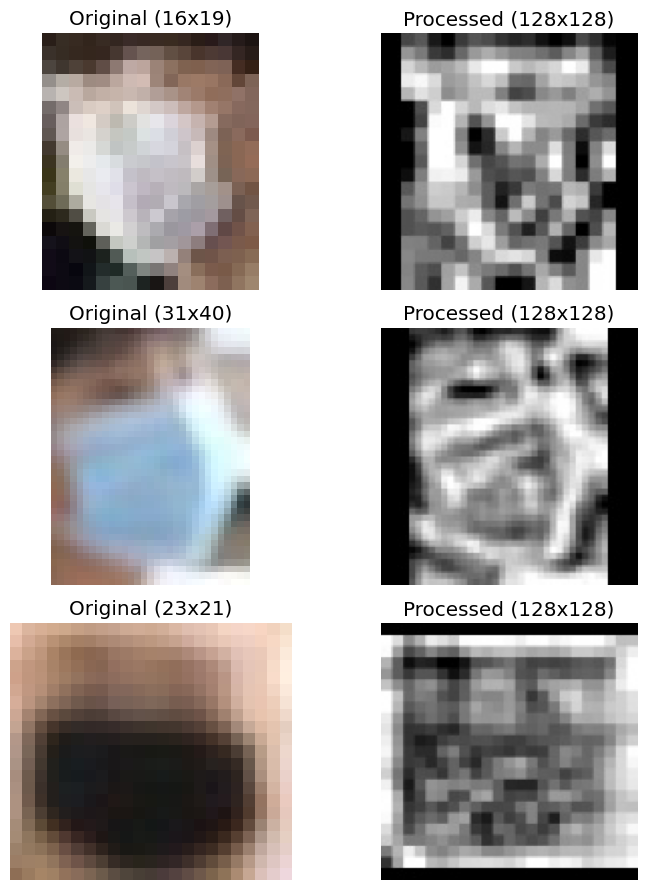

In [15]:
visualizeProcessedImages(str(trainImagePath), str(enhancedTrainImagePath), num_samples=3)

## Augmentation to handle class imbalance

In [16]:
# create augmentation directories
augDataPath = outputRoot / "AugmentedData" / "images"
augLabelPath = outputRoot / "AugmentedData" / "labels"

for path in [augDataPath, augLabelPath]:
    path.mkdir(parents=True, exist_ok=True)

print("Created directories for augmented data")

mild_aug = iaa.Sequential([
    iaa.Fliplr(0.5),  # 50% horizontal flip
    iaa.Affine(rotate=(-10, 10)),  # small rotation ±10 degrees
    iaa.MultiplyBrightness((0.9, 1.1))  # slight brightness changes
])

medium_aug = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(
        rotate=(-15, 15),
        scale=(0.9, 1.1)  
    ),
    iaa.MultiplyBrightness((0.85, 1.15)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.03*255))  # Light noise
])

strong_aug = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(
        rotate=(-15, 15),
        scale=(0.85, 1.15),
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
    ),
    iaa.MultiplyBrightness((0.8, 1.2)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),
    iaa.LinearContrast((0.9, 1.1))
])

Created directories for augmented data


In [18]:
def get_label(label_path, filename):
    label_file = filename.replace('.jpeg', '.txt')
    with open(os.path.join(label_path, label_file), 'r') as f:
        return int(f.read().strip())


In [19]:

# initialize counter for augmented imgs
augmented_counts = {0: 0, 1: 0, 2: 0}

print("Generating augmented images...")

# recollect the remaining training images after validation split
train_files = [f for f in os.listdir(enhancedTrainImagePath) if f.endswith('.jpeg')]
# remaining_label_files = [f.replace('.jpeg', '.txt') for f in remaining_train_files]

# regroup images by class
class_images = {0: [], 1: [], 2: []}
for img_file in train_files:
    label = get_label(enhancedTrainLabelPath, img_file)
    class_images[label].append(img_file)


print(f"Current training class distribution before augmentation:")
print(f"Class 0: {len(class_images[0])}, Class 1: {len(class_images[1])}, Class 2: {len(class_images[2])}")

# Class 0 - no mask (augment ~3x)
multiplier = 3
for i in tqdm(range(multiplier-1), desc="Augmenting Class 0 (No Mask)"):
    for img_file in class_images[0]:
        img_path = os.path.join(enhancedTrainImagePath, img_file)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            continue
        
        # apply medium augmentation
        aug_img = medium_aug(image=img)
        
        # generate new filename
        base_name = os.path.splitext(img_file)[0]
        new_img_file = f"{base_name}_aug_{i}.jpeg"
        new_label_file = f"{base_name}_aug_{i}.txt"
        
        # save augmented image
        cv2.imwrite(os.path.join(augDataPath, new_img_file), aug_img)
        
        # copy label (same class)
        with open(os.path.join(augLabelPath, new_label_file), 'w') as f:
            f.write('0')
            
        augmented_counts[0] += 1

# Class 2 - improper mask (augment ~10x)
multiplier = 10
for i in tqdm(range(multiplier-1), desc="Augmenting Class 2 (Improper Mask)"):
    for img_file in class_images[2]:
        img_path = os.path.join(enhancedTrainImagePath, img_file)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            continue
        
        aug_img = strong_aug(image=img)
        
        base_name = os.path.splitext(img_file)[0]
        new_img_file = f"{base_name}_aug_{i}.jpeg"
        new_label_file = f"{base_name}_aug_{i}.txt"
        
        cv2.imwrite(os.path.join(augDataPath, new_img_file), aug_img)
        
        with open(os.path.join(augLabelPath, new_label_file), 'w') as f:
            f.write('2')
            
        augmented_counts[2] += 1

Generating augmented images...
Current training class distribution before augmentation:
Class 0: 376, Class 1: 1940, Class 2: 78


Augmenting Class 2 (Improper Mask): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.97it/s]


In [22]:
# report final counts
class_counts = {label: len(class_images[label]) for label in class_images}

total_original = sum(class_counts.values())
total_augmented = sum(augmented_counts.values())
total_final = total_original + total_augmented

print("\nAugmentation Summary:")
print(f"Original dataset: {total_original} images")
print(f"Added through augmentation: {total_augmented} images")
print(f"Final augmented dataset: {total_final} images")

print("\nClass distribution:")
print(f"Class 0 (No Mask): {class_counts[0]} original + {augmented_counts[0]} augmented = {class_counts[0] + augmented_counts[0]} total")
print(f"Class 1 (Mask): {class_counts[1]} original + {augmented_counts[1]} augmented = {class_counts[1] + augmented_counts[1]} total")  
print(f"Class 2 (Improper Mask): {class_counts[2]} original + {augmented_counts[2]} augmented = {class_counts[2] + augmented_counts[2]} total")


Augmentation Summary:
Original dataset: 2394 images
Added through augmentation: 1454 images
Final augmented dataset: 3848 images

Class distribution:
Class 0 (No Mask): 376 original + 752 augmented = 1128 total
Class 1 (Mask): 1940 original + 0 augmented = 1940 total
Class 2 (Improper Mask): 78 original + 702 augmented = 780 total


In [23]:
# final summary
print(f"   - Processed {len(trainImages)} training images and {len(testImages)} test images")
print(f"   - Used full preprocessed training set of {len(train_files)} images (no validation split)")
print(f"   - Augmented underrepresented classes: Class 0 (No Mask) and Class 2 (Improper Mask)")
print(f"   - Added {augmented_counts[0]} images to Class 0 (No Mask)")
print(f"   - Added {augmented_counts[2]} images to Class 2 (Improper Mask)")
print(f"   - Final augmented dataset contains {total_final} images")



   - Processed 2394 training images and 458 test images
   - Used full preprocessed training set of 2394 images (no validation split)
   - Augmented underrepresented classes: Class 0 (No Mask) and Class 2 (Improper Mask)
   - Added 752 images to Class 0 (No Mask)
   - Added 702 images to Class 2 (Improper Mask)
   - Final augmented dataset contains 3848 images


### Stratified K-Fold Setup


In [11]:
from sklearn.model_selection import StratifiedKFold
import json

augDataPath = outputRoot / "AugmentedData" / "images"
augLabelPath = outputRoot / "AugmentedData" / "labels"

# collect image label pairs from both enhanced+augmented sets
def collect_dataset(image_dir, label_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpeg')])
    image_paths = []
    labels = []
    
    for fname in image_files:
        label_path = os.path.join(label_dir, fname.replace('.jpeg', '.txt'))
        with open(label_path, 'r') as f:
            label = int(f.read().strip())
        image_paths.append(os.path.join(image_dir, fname))
        labels.append(label)
    
    return image_paths, labels

# combine enhanced+augmented data
enhanced_imgs, enhanced_labels = collect_dataset(enhancedTrainImagePath, enhancedTrainLabelPath)
augmented_imgs, augmented_labels = collect_dataset(augDataPath, augLabelPath)

# the full dataset 
full_image_paths = enhanced_imgs + augmented_imgs
full_labels = enhanced_labels + augmented_labels

print(f"Total images: {len(full_image_paths)}")
print(f"Class distribution: {Counter(full_labels)}")


Total images: 3848
Class distribution: Counter({1: 1940, 0: 1128, 2: 780})


In [12]:
# create stratified K-Fold split indices
n_splits = 5  
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

folds = {}

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(full_image_paths, full_labels)):
    folds[fold_idx] = {
        'train': train_idx.tolist(),
        'val': val_idx.tolist()
    }

# Save the folds to JSON file
fold_path = outputRoot / "kfold_splits.json"
with open(fold_path, "w") as f:
    json.dump(folds, f)

print(f"Generated {len(folds)} stratified folds.")
print(f"Saved k-fold splits to: {fold_path}")

Generated 5 stratified folds.
Saved k-fold splits to: /mnt/c/3rd year uni/IN1 Computer Vision/MaskDetection/ModifiedDataset/kfold_splits.json


In [13]:
# Check class distribution in each fold
for fold_idx in folds:
    train_indices = folds[fold_idx]['train']
    val_indices = folds[fold_idx]['val']
    
    # Get labels for these indices
    train_labels = [full_labels[idx] for idx in train_indices]
    val_labels = [full_labels[idx] for idx in val_indices]
    
    train_dist = Counter(train_labels)
    val_dist = Counter(val_labels)
    
    print(f"\nFold {fold_idx}")
    print(f"Train - Class 0: {train_dist[0]}, Class 1: {train_dist[1]}, Class 2: {train_dist[2]}")
    print(f"Val - Class 0: {val_dist[0]}, Class 1: {val_dist[1]}, Class 2: {val_dist[2]}")


Fold 0
Train - Class 0: 902, Class 1: 1552, Class 2: 624
Val - Class 0: 226, Class 1: 388, Class 2: 156

Fold 1
Train - Class 0: 902, Class 1: 1552, Class 2: 624
Val - Class 0: 226, Class 1: 388, Class 2: 156

Fold 2
Train - Class 0: 902, Class 1: 1552, Class 2: 624
Val - Class 0: 226, Class 1: 388, Class 2: 156

Fold 3
Train - Class 0: 903, Class 1: 1552, Class 2: 624
Val - Class 0: 225, Class 1: 388, Class 2: 156

Fold 4
Train - Class 0: 903, Class 1: 1552, Class 2: 624
Val - Class 0: 225, Class 1: 388, Class 2: 156


## Stratified K-Fold Setup Summary

- **Stratified** K-Fold maintains class distribution across all folds, which is important because of our imbalanced dataset
- Chose **5 folds** as a balanced trade-off:
  - leads to more stable validation results 
  - Not as  computationally expensive as higher folds
- The splits are saved in `ModifiedDataset/kfold_splits.json` so that:
  - All models (SVM, MLP, CNN) will use the *same* train/val sets per fold
  - Evaluation across models is fair and consistent.
